In [1]:
import numpy as np

X = np.load('model_train/train/inputs.npy')
T = np.load('model_train/train/targets.npy')

classes = int(T.max()) + 1
X.shape, T.shape, classes

((8606, 256, 256), (8606,), 232)

In [2]:
import os

import torch
from ipynb.fs.defs.model import create_model
from torch.nn import CrossEntropyLoss
from torch.optim import AdamW

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = create_model(classes, device)

optim = AdamW(model.parameters(), lr=1e-5)
loss_fn = CrossEntropyLoss()

In [3]:
N = X.shape[0]
X = X.reshape((N, 1, 256, 256)) # reshape to 1-channel for convolutions

X_train = torch.tensor(X, device=device, dtype=torch.float32)
y_train = torch.tensor(T, device=device, dtype=torch.long)

In [4]:
o = model(X_train[:1])
loss_fn(o, y_train[:1])

tensor(5.4468, device='cuda:0', grad_fn=<NllLossBackward0>)

In [5]:
from ipynb.fs.defs.model import train

t_l, v_l = train(model, 100, X_train, y_train, optim, loss_fn, bs=64, random_seed=None)

Starting training.
Number of minibatches for training/test: 118/17
Starting epoch 1 of 100


c:\Users\cupof\repos\audio-project\.venv\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
c:\Users\cupof\repos\audio-project\.venv\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


	Training took: 196.23s	with loss: 5.391173
Starting epoch 2 of 100
	Training took: 192.69s	with loss: 5.386281
Starting epoch 3 of 100
	Training took: 193.34s	with loss: 5.377791
Starting epoch 4 of 100
	Training took: 190.46s	with loss: 5.353819
Starting epoch 5 of 100
	Training took: 190.93s	with loss: 5.346120
Starting epoch 6 of 100
	Training took: 191.44s	with loss: 5.343428
Starting epoch 7 of 100
	Training took: 198.64s	with loss: 5.327948
Starting epoch 8 of 100
	Training took: 200.81s	with loss: 5.293121
Starting epoch 9 of 100
	Training took: 195.46s	with loss: 5.286651
Starting epoch 10 of 100
	Training took: 191.61s	with loss: 5.280585
Starting epoch 11 of 100
	Training took: 187.40s	with loss: 5.256141
Starting epoch 12 of 100
	Training took: 201.48s	with loss: 5.236308
Starting epoch 13 of 100
	Training took: 186.37s	with loss: 5.217008
Starting epoch 14 of 100
	Training took: 171.55s	with loss: 5.193054
Starting epoch 15 of 100
	Training took: 171.52s	with loss: 5.17080

In [6]:
np.save('train_losses_new.npy', t_l)
np.save('valid_losses_new.npy', v_l)

In [9]:
t_l = []
v_l = []

ckpt_path = 'checkpoints/11-06-2024-11-35-39'

for f in os.listdir(ckpt_path):
    if not f.endswith('.pt'):
        continue
    ckpt = torch.load(os.path.join(ckpt_path, f))
    t_l.append(ckpt['train_loss'])
    v_l.append(ckpt['valid_loss'])

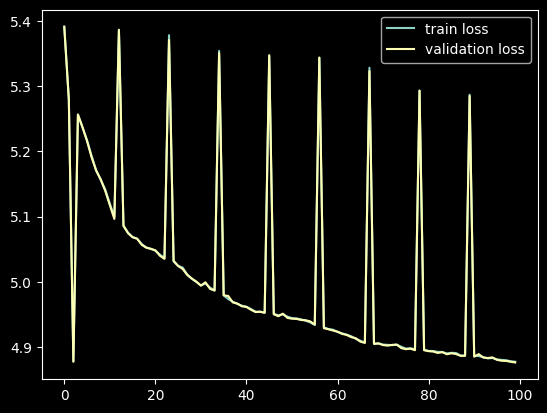

In [10]:
import matplotlib.pyplot as plt

n = len(t_l)

ax = plt.subplot()
ax.plot(np.arange(n), t_l, label='train loss')
ax.plot(np.arange(n), v_l, label='validation loss')
plt.legend()

In [11]:
from ipynb.fs.defs.model import eval_acc, load_model_checkpoint

accs = [0] * 100
model.eval()

# ckpt_path = 'checkpoints/10-06-2024-19-38-18'

for f in os.listdir(ckpt_path):
    if not f.endswith('.pt'):
        continue
    model_file = os.path.join(ckpt_path, f)
    ckpt = load_model_checkpoint(model_file, model, device=device)
    # ckpt = torch.load(model_file, map_location='cuda')
    acc = eval_acc(model, X_train, y_train)
    accs[ckpt['epoch']] = acc

c:\Users\cupof\repos\audio-project\.venv\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


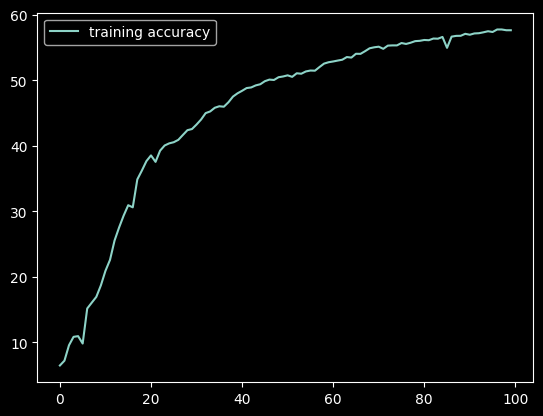

In [12]:
import matplotlib.pyplot as plt

np_accs = np.array(accs) * 100

ax = plt.subplot()
ax.plot(np.arange(len(accs)), np_accs, label='training accuracy')
plt.legend()